<a href="https://colab.research.google.com/github/munich-ml/BER_tail_fit/blob/main/Jitter_BER_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jitter and BER 
*H. Steffens, April 2021*

This Notebook contains an introduction into Jitter, its correlation to BER (bit error ratio) and how to measure Jitter, particulatly using Xilinx FPGA's with IBERT.

### Jupyter setup
Required Python imports and helper functions


In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import special
from scipy.stats import norm
from lib.helper_funcs import JitterEstimator, plot_jitter_fit, plot_jitter_overlay

In [18]:
np.random.seed(22)

In [19]:
def get_url(image_name):
    return "https://github.com/munich-ml/BER_tail_fit/blob/main/images/{}.png?raw=true".format(image_name)

# Introduction to Jitter

**Jitter** is the **timing uncertainty** of signal edges at the crossing point with their reference level (0V for differential signaling).

Since **Noise** describes a level uncertainty, **timing noise** or **phase noise** (usually used in frequency domain).

![nice](https://github.com/munich-ml/BER_tail_fit/blob/main/images/RJeye_dscr.png?raw=true)

The **Total Jitter (TJ)** consists of 2 major components:

**Random Jitter (RJ)**
- unbounded --> increases over time
- Gaussian distribution

**Deterministic Jitter (DJ)**
- bounded --> saturates over time 
- can be split into sub-components (e.g. PJ, DCD, ISI)




### Jitter in a transmission system

![Tx+channel+Rx](https://github.com/munich-ml/BER_tail_fit/blob/main/images/tx_channel_rx.png?raw=true)

The Jitter needs to be small enough for the receiver to sample the `rx_data`, while satisfying its setup- and hold-requirements.


# Measure Jitter using a Scope

A scope (realtime oscilloscope) measures jitter directly with the following basic procedure: 
- **wavetrace acquisition** (voltage over time bitstream)
- **edge extraction** (signal crossings with the reference voltage)
- **clock recovery from data** (or usage of a strobe for source syncronous clocking schemas)
- **data eye creastion** (see Tectronix Primer)
- **jitter** (or TIE: time interval error) is now given as edge distribution (e.g. Gaussian shaped)

![eye_creation](https://github.com/munich-ml/BER_tail_fit/blob/main/images/eye_creation.png?raw=true)

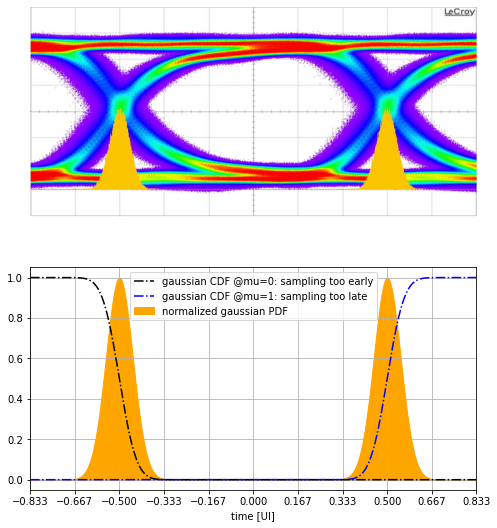

In [20]:
x = np.linspace(-5/6, 5/6, num=500)
scale = 0.05    # sigmal value of the gaussian distribution
norm_pdf = norm.pdf(x, loc=-0.5, scale=scale) + norm.pdf(x, loc=0.5, scale=scale) 
too_early = 1 - norm.cdf(x, loc=-0.5, scale=scale) 
too_late = norm.cdf(x, loc=0.5, scale=scale) 

plt.figure(figsize=(8, 9)), plt.subplot(2,1,1)
plt.imshow(plt.imread(get_url("RJeye"))), plt.axis("off")

plt.subplot(2,1,2)
plt.fill_between(x, norm_pdf / norm_pdf.max(), color="orange", label="normalized gaussian PDF")
plt.plot(x, too_early, "k-.", label="gaussian CDF @mu=0: sampling too early")
plt.plot(x, too_late, "b-.", label="gaussian CDF @mu=1: sampling too late")
plt.xlim([min(x), max(x)]), plt.xticks(np.linspace(min(x), max(x), num=11))
plt.xlabel("time [UI]"), plt.grid(), plt.legend();

The example above shows a data eye together with the distribution of it's crossings (jitter distribution. PDF).

Integrating the PDF provides the likelyhood of sampling too early or to late (CDF).


### Disadvantages of Jitter measurements using Scopes
Although (realtime-) scopes are are very useful tool when analysing communication systems with respect to Jitter, their usage comes with some disadvantages:
- scopes and probes are expensive
- measurements are only available on individual samples and/or only during test  
- the probes changes the channel, when being applied
- the probes is placed somewhere on the channel, not at the receiver

The **in-system measurement** approach proposed in the next chapter can potentially mitigate or even solve those issues.

# Bit error ratio $BER$

The **bit error ratio ($BER$)** is a *figure of merit* for a link quality, commonly used in communications engineering.

The $BER$ described, how many bit errors there are (on average) within the received data stream: $BER=\frac{error\_bits}{received\_bits}$

A typical specification is: $BER < 10^{-12}$

This chapter shows that $BER$ and **Jitter** tightly related to each other.

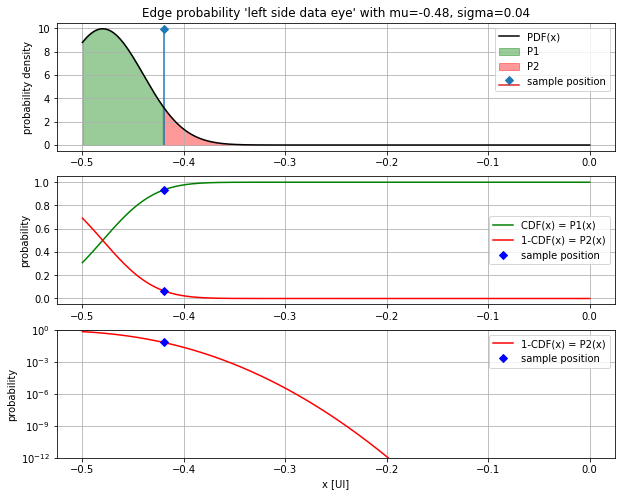

In [21]:
mu = -0.48         # mean value of the distribution 
sigma = 0.04       # standard deviation
ui_pos = -0.42     # sample position (example)
x = np.linspace(-0.5, 0, 500)  
pdf = norm.pdf(x, loc=mu, scale=sigma)  # compute pdf for variable x

def cdf(x):  # define the CDF (cumulative density function) using the erf (error function)
    return 0.5 * (1+special.erf( (x-mu)/(np.sqrt(2)*sigma) ))

plt.figure(figsize=(10,8)), plt.subplot(3,1,1)
plt.plot(x, pdf, "k", label="PDF(x)")
plt.stem([ui_pos], [max(pdf)], markerfmt='D', use_line_collection=True, label="sample position")
plt.fill_between(x[x <= ui_pos], pdf[x <= ui_pos], color="green", alpha=0.4, label="P1")
plt.fill_between(x[x > ui_pos], pdf[x > ui_pos], color="red", alpha=0.4, label="P2")
plt.title(f"Edge probability 'left side data eye' with mu={mu}, sigma={sigma}")
plt.ylabel("probability density"), plt.legend(), plt.grid()

plt.subplot(3,1,2)
plt.plot(x, cdf(x), "g", label="CDF(x) = P1(x)")
plt.plot(x, 1-cdf(x), "r", label="1-CDF(x) = P2(x)")
plt.plot(2*[ui_pos], [cdf(ui_pos), 1-cdf(ui_pos)], "bD", label="sample position")
plt.ylabel("probability"), plt.legend(), plt.grid();

plt.subplot(3,1,3)
plt.semilogy(x, 1-cdf(x), "r", label="1-CDF(x) = P2(x)")
plt.semilogy([ui_pos], [1-cdf(ui_pos)], "bD", label="sample position")
plt.ylabel("probability"), plt.ylim([1e-12, 1])
plt.xlabel("x [UI]"), plt.legend(), plt.grid();

The **edge distribution** at $\pm\frac{1}{2}UI$ is assumed to have a **gaussian distribution** according to  

> $PDF(x) = \frac{1}{\sigma\sqrt{2\pi} }e^{-\frac{(x - \mu)^{2}}{2\sigma^2}}$
> 
> with
> - $PDF$ = normal probability density function, available in [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html?highlight=stats%20norm#scipy.stats.norm)
> - $\sigma$ (*sigma*) = standard deviation
> - $\mu$ (*mu*) = mean value 

When looking for the `bit error count`, 
- all edges **left** from the `sample position` within $-\frac{1}{2}UI  \cdots 0UI$ provide good data, 
- while all edges **right** from the `sample position` provide data from the previous Unit Interval, thus **bit errors** at a rate of 0.5 (because every other bit is statistically right, if there are just *ones* and *zeros*)

Therefore, the area $P2$ represents the $BER$ (Bit Error Ratio) with

> $BER = \frac{1}{2}{P2}$

The **integration of the Gaussian** can be done by means of the **Error Function** $erf(x)$, which is nicely decribed in 
[Integration of Gaussian between limits](https://www.youtube.com/watch?v=26QbWYBCw7Y): 

> $CDF(x) = \frac{1}{2}[1+erf(\frac{x-\mu}{\sigma\sqrt2})]$
>
> with
> - $CDF$ = cumulative density function of a Gaussian
> - $erf$ = error function
> - $\sigma$ (*sigma*) = standard deviation
> - $\mu$ (*mu*) = mean value 

Just for reference, the Error Function is defined as:

> $erf(x)=\frac2{\sqrt{\pi}}\int_0^x e^{-t^2} \,dt$

Returning to the **data eye problem**, the $CDF(sample\_position)$ equals the area $P1$, and therefore:

> $BER = \frac{1}{2}[1-CDF(x)] = \frac{1}{4}[1-erf(\frac{x-\mu}{\sigma\sqrt2})]$

With the **[complementary error function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfc.html)** $erfc(x) = 1-erf(x)$, we get:

> $BER = \frac{1}{4} erfc(\frac{x-\mu}{\sigma\sqrt2})$

This equation needs to be resolved for $x$, because the we need to find the $sample\_position$ for a given $BER$. Fortunatelly, there is an **[inverse compementary error function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.erfcinv.html#scipy.special.erfcinv)** $erfcinv$, which leads to the final equation:

> $x = erfcinv(4BER)\ \sigma\sqrt2 + \mu$ 
>
> again with
> - $x$ = sample position (on the left half of the unit inverval)
> - $erfcinv$ = inverse compementary error function
> - $BER$ = Bit Error Ratio, at which distribution is evaluated
> - $\sigma$ (*sigma*) = standard deviation of the Gaussian
> - $\mu$ (*mu*) = mean value of the Gaussian


# FPGA build-in BERT

FPGA-maker XILINX offers **Integrated Bit Error Ratio Tester IBERT** for their [7-Series GTP transceivers](https://www.xilinx.com/support/documentation/white_papers/wp428-7Series-Serial-Link-Signal-Analysis.pdf) and [UltraScale/UltraScale+ GTX and GTY transceivers](https://www.xilinx.com/products/intellectual-property/ibert_ultrascale_gth.html#overview).


![WP482](https://github.com/munich-ml/BER_tail_fit/blob/main/images/wp482.png?raw=true)


## Evaluating test data
The folloging example data has been aquired on an [Avnet AES-KU040-DB-G evaluation board](https://github.com/munich-ml/BER_tail_fit/blob/main/literature/FPGA_EvalBoard.pdf), populated with an Xilinx Kintex® UltraScale™ FPGA. 

The data is provided in the `datasets` directory in JSON format and library function are also provided in the `lib` directory.

In [22]:
filesDir = os.path.join(os.getcwd(), "datasets")
fns = os.listdir(filesDir)
fns

FileNotFoundError: ignored

The **Jitter fits** shown below appear reasonable. The two channels `C9` and `C10` are quite different in terms of Jitter performance which is expected, because their channels are different:
- `C9`: FPGA GTX transceiver connected via 10G SFP+ transceivers and a fiber-loopback
- `C10`: FPGA GTX transceiver connected via SMA to 2x 0.5m cheap RG58 copper-loopback cables

In [ ]:
plot_jitter_fit(os.listdir(filesDir)[0], filesDir, exclude_chs=[8, 11])

The RJ and TJ peak-2-peak values are estimated for $BERs=10^{-12}$.

The images above show, that the **Gaussian model** fits well for low $BER$ below ~$10^{-4}$ ($BERt$ = threshold).

The next image is an overlay of the examples above:

In [ ]:
plot_jitter_overlay(os.listdir(filesDir)[0], filesDir, exclude_chs=[8, 11], figsize=(12,3))

## Jitter extrapolation to $BER=10^{-12}$ 



Modeling the RJ behaviour is helpful to estimate the *long-term* Jitter performance with a *short* test. As an example, the same set of channels (C8..C11) have been tested twice with different `targetBER` (testtime):

- `jitter_long_` with `targetBER=1E-12`
- `jitter_short_` with `targetBER=1E-8`, thus a difference of faktor 10.000 in testtime!

In [ ]:
plot_jitter_overlay(os.listdir(filesDir), filesDir, exclude_chs=[])

Evaluation:

- Within each trace, the fitted samples (`X`) are well on the trace. Thus, the method of fitting a Gaussian seems valid.
- If short-term / long-term measurements differ in $sigma$/`RJrms`, the short-term measurement is worse. Thus, extrapotating from short-term is conservative.
- Some short-term / long-term measurements differ in $mu$/`DJ`
> - todo: Verify reproducability (incl. tester warm-up)

# Conclusion

# Appndix: Jitter and BER Simulation

Setting-up the simulation

In [ ]:
N = int(4e5)      # number of simulated bits
DR = 1e9          # data rate [bits/s]
UI = 1/DR         # unit interval [s]
RJ_SIGMA = 0.025  # simulated random jitter's sigma
PJ_FREQ = 3e5     # frequency of the periodic jitter
PJ_AMPL = 0.1     # periodic jitter amplitude [UI]

In [ ]:
t = np.linspace(start=0, stop=(N-1)*UI, num=N)   # time vector
dj = PJ_AMPL * np.sin(2 * np.pi * PJ_FREQ * t)   # determistic jitter,  consists of PJ, only
rj = RJ_SIGMA * np.random.randn(N)               # random jitter
tj = rj + dj                                     # total jitter

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(tj, ".", label="TJ");
plt.plot(rj, ".", label="RJ");
plt.plot(dj, ".", label="DJ");
plt.xlabel("time [UI]"), plt.ylabel("jitter [UI]")
plt.xlim([0, 7000])
plt.legend(loc="best"), plt.grid(), plt.tight_layout();

In [ ]:
bins = np.linspace(-0.5, 0.5, 300)
plt.figure(figsize=(12, 4))
plt.hist(tj, bins=bins, histtype="stepfilled", label="TJ")
plt.hist(rj, bins=bins, histtype="step", linewidth=4, label="RJ")
plt.hist(dj, bins=bins, histtype="step", linewidth=4, label="DJ")
plt.yscale("log")
plt.ylabel("counts per bin"), plt.xlabel("jitter [UI]")
plt.legend(loc="best"), plt.grid(), plt.tight_layout();

Random bit sequence as data

In [ ]:
data = np.random.randint(0, 2, N)

In [ ]:
plt.figure(figsize=(14, 1.2))
n = 100    # number of bits shown
sns.lineplot(x=t[:n]*1e9, y=data[:n], drawstyle='steps-post')
plt.title(f"first {n} bits of the data")
plt.xlabel("t [ns]"), plt.ylabel('level ["arbitraty"]');

**Data sampling and error checking**


Create a receiver sampler with `65` steps within the unit interval

In [ ]:
RX_PI_STEPS = 65          # step count of the receiver phase interpolator
rx_pi = np.linspace(0, 1, num=RX_PI_STEPS)

Cheching for errors

In [ ]:
errors = []
for rx_pi_step in rx_pi:
    errors.append(0)      # start with 0 errors at each new RX PI step
    for i, tj_sample in enumerate(tj):
        if 0 < i < N-1:                      # allows sampling data[i-1], data[i+1] 
            if tj_sample > rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i-1], data[i]))
            if 1 + tj_sample < rx_pi_step:         # checking left side eye
                errors[-1] += int(np.logical_xor(data[i+1], data[i]))

Compute and plot BER

In [ ]:
ber = np.array(errors) / N

In [ ]:
plt.figure(figsize=(10, 4.5))
plt.semilogy(rx_pi, ber, "rX", label="measured BER")
plt.semilogy([0, 1], [1/N, 1/N], "-b", label="actual test deapth")
plt.semilogy([0, 1], [1e-12, 1e-12], "-g", label="desired test deapth")
plt.xlabel("RX PI position [UI]"), plt.ylabel("BER")
plt.xlim([0, 1]), plt.ylim([1e-14, 1])
plt.legend(), plt.grid();